In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
import json
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [206]:
df = pd.read_csv('./data/dataset_families.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language Family
83553,aurelie trois ans,Romance
52081,eikhe koubalesei to,Hellenic
251346,kauhistui han kauhistui,Uralic
15691,tes ste sebasuia,Hellenic
226989,poslednich za poslednich,Slavic


In [207]:
df.shape

(292675, 2)

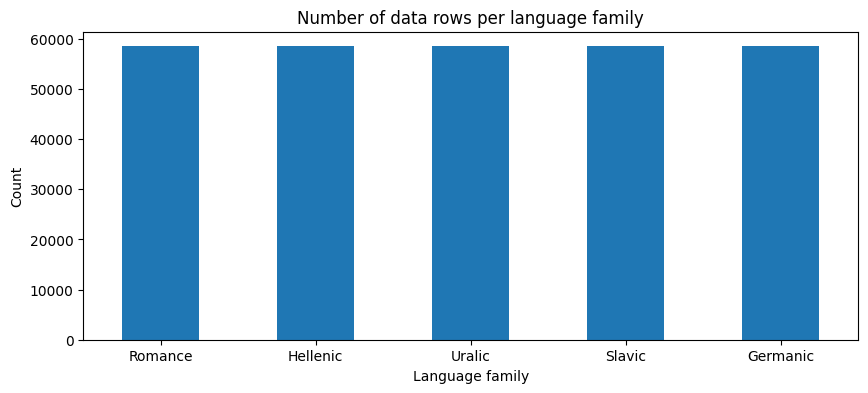

In [208]:
category_counts = df.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 4))
category_counts.plot(kind='bar')
plt.title('Number of data rows per language family')
plt.xlabel('Language family')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [230]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Max input length: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of language families to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Max input length: 40
Rows: 292675
Amount of language families to identify: 5


In [235]:
nodel = Sequential()

nodel.add(Conv1D(input_dim, kernel_size=2, activation='relu'))
nodel.add(LSTM(32, return_sequences=True))
nodel.add(Flatten())
nodel.add(Dropout(0.5))
nodel.add(Dense(len(y[1]), activation='softmax'))

adam = optimizers.legacy.Adam(learning_rate=0.01)
nodel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
nistory = nodel.fit(X_train.astype('float32'), y_train.astype('float32'), validation_data=(X_val, y_val), epochs=30, batch_size=2048,verbose=1)


Epoch 1/30
 23/115 [=====>........................] - ETA: 8s - loss: 1.6110 - accuracy: 0.2016

KeyboardInterrupt: 

In [210]:
model = Sequential()

model.add(Conv1D(input_dim, kernel_size=2, activation='relu'))
model.add(LSTM(256, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))

adam = optimizers.legacy.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [211]:
history = model.fit(X_train.astype('float32'), y_train.astype('float32'), validation_data=(X_val, y_val), epochs=30, batch_size=2048,verbose=1)

Epoch 1/30
115/115 [==============================] - 79s 672ms/step - loss: 1.7041 - accuracy: 0.3323 - val_loss: 1.3877 - val_accuracy: 0.4044
Epoch 2/30
115/115 [==============================] - 75s 654ms/step - loss: 1.3666 - accuracy: 0.4198 - val_loss: 1.3264 - val_accuracy: 0.4401
Epoch 3/30
115/115 [==============================] - 78s 677ms/step - loss: 1.2868 - accuracy: 0.4662 - val_loss: 1.2077 - val_accuracy: 0.5056
Epoch 4/30
115/115 [==============================] - 76s 663ms/step - loss: 1.1771 - accuracy: 0.5220 - val_loss: 1.1308 - val_accuracy: 0.5502
Epoch 5/30
115/115 [==============================] - 74s 644ms/step - loss: 1.0644 - accuracy: 0.5799 - val_loss: 1.0257 - val_accuracy: 0.5926
Epoch 6/30
115/115 [==============================] - 74s 644ms/step - loss: 0.9517 - accuracy: 0.6320 - val_loss: 0.8934 - val_accuracy: 0.6591
Epoch 7/30
115/115 [==============================] - 74s 644ms/step - loss: 0.8568 - accuracy: 0.6751 - val_loss: 0.7884 - val_ac

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

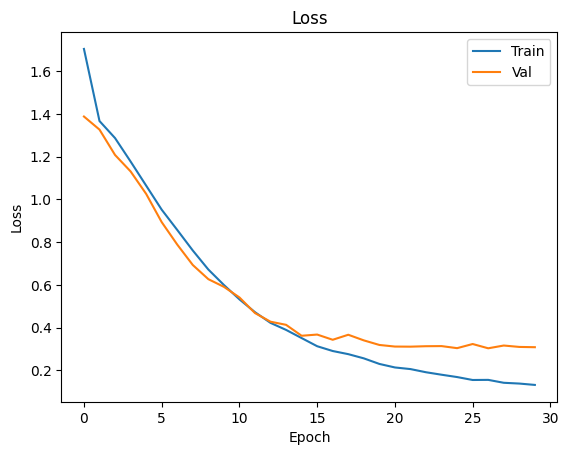

In [212]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Accuracy evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

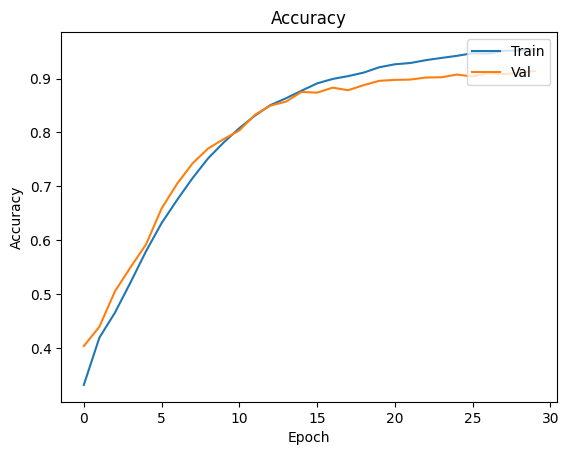

In [213]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [226]:
prediction_word = ("en dårlig bearnaise sovs")
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}%")

Text before preprocessing: en dårlig bearnaise sovs
Text after preprocessing: en darlig bearnaise sovs en darlig bearnaise
1/1 [==============================] - 0s 16ms/step
Language Family_Germanic: 54.5%
Language Family_Hellenic: 0.0%
Language Family_Romance: 43.1%
Language Family_Slavic: 1.1%
Language Family_Uralic: 1.3%


# Confusion Matrix

In [221]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_val = y_val.flatten()
cm = confusion_matrix(y_val, y_pred)

print(cm)
TN, FP, FN, TP = cm.ravel()

# Compute metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {round(accuracy*100, 1)}%")
print(f"Precision: {round(precision*100, 1)}%")
print(f"Recall: {round(recall*100, 1)}%")
print(f"F1 score: {round(f1_score*100, 1)}%")

1830/1830 [==============================] - 23s 12ms/step
[[229508   4632]
 [  5300  53235]]
Accuracy: 96.6%
Precision: 92.0%
Recall: 90.9%
F1 score: 91.5%


# Save model
Here, a model can be saved

In [216]:
model.save('./models/model_families.keras')
tokenizer_json = tokenizer.to_json()
with open('./tokenizer_configs/tokenizer_config_families.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Load model
Here a model can be loaded

In [217]:
model = load_model('./models/model_families.keras')